# Read HDF5 File

*Author: Creare* <br>
*Date: April 01 2020* <br>

**Keywords**: podpac, DataSource, HDF5, netCDF

## Overview

Reference tutorial for loading data from an HDF5 formatted (i.e. netCDF) file using the `podpac.data.H5PY` Node.

### Prerequisites

- Python 2.7 or above
- [`podpac[datatype]`](https://podpac.org/install.html#install)
- *Review the [README.md](../README.md) and [jupyter-tutorial.ipynb](jupyter-tutorial.ipynb) for additional info on using jupyter notebooks*

### See Also

- [0-concepts/introduction.ipynb](introduction.ipynb): PODPAC introduction
- [0-concepts/coordinates.ipynb](../0-concepts/coordinates.ipynb): PODPAC Coordinates reference
- [csv-file.ipynb](csv-file.ipynb): PODPAC CSV DataSource
- [`podpac.data.H5PY` API Reference](https://podpac.org/api/podpac.data.H5PY.html#podpac.data.H5PY)

## Open Simple HDF5 file

The `podpac.data.H5PY` node reads HDF5 formatted files.
PODPAC wraps the [h5py](https://www.h5py.org/) Python package to read HDF5 files.

If the HDF5 file contains a data field that can be simply described by other array dimensions, then the H5PY node should work out of the box similar to a CSV file.

* Specify the key used for the data (`data_key`)
* Specify the key(s) used for the coordinates to describe the dimensions of `data_key`:
    * `lat_key`
    * `lon_key`
    * `time_key`
    * `alt_key`

In [1]:
# plot inline
%matplotlib inline

In [2]:
import podpac

# Path to the NetCDF file
# Root Zone Soil Moisture Data: https://disc.gsfc.nasa.gov/datasets/SMERGE_RZSM0_40CM_2.0/summary
filename = '../../data/raster/Smerge_Noah_CCI_L4_RZSM0_40cm_V2.0_20190510.nc4'

# Set up the PODPAC node to read this file.
# Note that the data array for this data_key has the dimensions [time, lat, lon]
# By default, the H5PY Node assumes array dimensions of [lat, lon, time], so we override the `array_dims` value in the Node
node = podpac.data.H5PY(source=filename, data_key="/RZSM", time_key="/time", lat_key="/lat", lon_key="/lon", array_dims=["time", "lat", "lon"])

node

<H5PY(source='../../data/raster/Smerge_Noah_CCI_L4_RZSM0_40cm_V2.0_20190510.nc4', interpolation='nearest', data_key='/RZSM')>

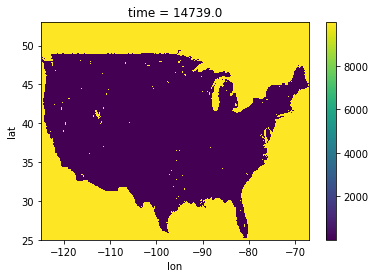

In [3]:
# retrieve all of the data at the native resolution into memory and plot
output = node.eval(node.native_coordinates)
output.plot()
pass

## Open Complex HDF5 file

If the data in your HDF5 file is not compatible with the `podpac.data.H5PY` node out-of-the-box, you will have to create a custom Node to interpret the data in your file.
  
This takes a little more work and is *and is signifigantly more complicated*.
We encourage users to contribute wrappers for datasets. 
We welcome pull requests to the `podpac.datalib` module of the PODPAC repository.
**One of PODPAC's goals is to share the work of wrapping important datasets.**

With that caveat, lets put together a Node to interpret a SMAP formatted HDF5 file: `'../../data/raster/SMAP_L4_SM_aup_20181027T090000_Vv4030_001.h5'`

So, we have to:

1. Find the *keys* for the data we want
2. Tell PODPAC how to find and arrange the coordinates of the data

The example below is relatively streamlined, but each new dataset may require some iteration. For example, you'll have to consider the: 

* Order of the coordinates 
    * (lat, lon) vs (lon, lat)
* The dimension of the array
    * Is this a 2D array with lat-lon dimensions? 
    * Is this a 3D array with lat-lon-time dimensions?

In [4]:
import podpac

# Get the file path to the SMAP data in the podpac_examples repostiory
filename = '../../data/raster/SMAP_L4_SM_aup_20181027T090000_Vv4030_001.h5'

# Set up the PODPAC node to read this file so we can investigate the keys.
# Notice, we specify that the number -9999 should be interpreted as a 'nan' in Python.
node = podpac.data.H5PY(source=filename, nan_vals=[-9999])
node

<H5PY(source='../../data/raster/SMAP_L4_SM_aup_20181027T090000_Vv4030_001.h5', interpolation='nearest')>

## View keys

In [5]:
node.keys

['/Analysis_Data/sm_profile_analysis',
 '/Analysis_Data/sm_profile_analysis_ensstd',
 '/Analysis_Data/sm_rootzone_analysis',
 '/Analysis_Data/sm_rootzone_analysis_ensstd',
 '/Analysis_Data/sm_surface_analysis',
 '/Analysis_Data/sm_surface_analysis_ensstd',
 '/Analysis_Data/soil_temp_layer1_analysis',
 '/Analysis_Data/soil_temp_layer1_analysis_ensstd',
 '/Analysis_Data/surface_temp_analysis',
 '/Analysis_Data/surface_temp_analysis_ensstd',
 '/CCI_ano',
 '/EASE2_global_projection',
 '/Forecast_Data/sm_profile_forecast',
 '/Forecast_Data/sm_rootzone_forecast',
 '/Forecast_Data/sm_surface_forecast',
 '/Forecast_Data/soil_temp_layer1_forecast',
 '/Forecast_Data/surface_temp_forecast',
 '/Forecast_Data/tb_h_forecast',
 '/Forecast_Data/tb_h_forecast_ensstd',
 '/Forecast_Data/tb_v_forecast',
 '/Forecast_Data/tb_v_forecast_ensstd',
 '/Observations_Data/tb_h_obs',
 '/Observations_Data/tb_h_obs_assim',
 '/Observations_Data/tb_h_obs_errstd',
 '/Observations_Data/tb_h_obs_time_sec',
 '/Observations

The keys suggests we want `cell_lat` and `cell_lon` keys for `lat` and `lon` coordinates

We are interested in surface soil moisture, so let's use the `/Analysis_Data/sm_surface_analysis` key for our data.

We'll make a new DataSource class that tells PODPAC how to interpret the coordinates and data from the file.

In [6]:
# Define a new class, inheriting from the PODPAC H5PY class
class SMAPH5(podpac.data.H5PY):
    # key for data values
    data_key = '/Analysis_Data/sm_surface_analysis'
    
    # Overwrite the 'get_native_coordinates' function of podpac.data.H5PY
    # In this dataset, 'cell_lat' and 'cell_lon' are each 2D arrays with repeating values
    # We will assemble PODPAC coordinates from the first column of "cell_lat" 
    # and the first row of "cell_lon"
    def get_native_coordinates(self):
        lat = self.dataset['cell_lat'][:, 0]
        lon = self.dataset['cell_lon'][0, :]
        
        # the order is important: lat = rows of array, lon = cols of array
        return podpac.Coordinates([lat, lon], dims=['lat', 'lon'])

In [7]:
# Make a PODPAC node to read this file
node = SMAPH5(source=filename, nan_vals=[-9999])
node.native_coordinates

Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[-84.65644073486328, 84.65644073486328], N[1624], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-179.9533233642578, 179.9533233642578], N[3856], ctype['midpoint']

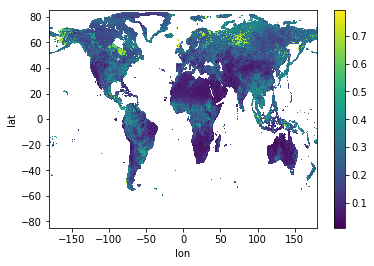

In [8]:
# retrieve all of the data at the native resolution into memory and plot
output = node.eval(node.native_coordinates)
output.plot()
pass

## Another NetCDF Example

In this case, the data key has an extra dimensions representing a qualitative field.
We will need to create a custom DataSource to handle this extra field.

In [9]:
import podpac

# Path to the NetCDF file
# CMS Flux: https://disc.gsfc.nasa.gov/datasets/CMS_CH4_FLX_NAD_1/summary
filename = '../../data/raster/CH4_flux_20110915.nc4'

# Set up the PODPAC node to read this file.
# Unfortunately, the data_key emissions is a 3D array, with the 0th row representing type of emissions (12 separate types)
node = podpac.data.H5PY(source=filename, data_key="/emissions", lat_key="/Lat", lon_key="/Lon")
node

<H5PY(source='../../data/raster/CH4_flux_20110915.nc4', interpolation='nearest', data_key='/emissions')>

In [10]:
node.dataset["emissions"]

<HDF5 dataset "emissions": shape (12, 121, 151), type "<f8">

In [11]:
# Define a new class, inheriting from the PODPAC H5PY class
class CH4_flux(podpac.data.H5PY):
    # keys for data values
    data_key = '/emissions'
    lat_key = '/Lat'
    lon_key = '/Lon'
    
    # Overwrite the 'get_data' function of podpac.data.H5PY
    # In this dataset, 'emissions' is a 3-D array with the row element
    # representing the source of the emissions.
    # See https://acdisc.gsfc.nasa.gov/data/CMS/CMS_CH4_FLX_NAD.1/doc/README.CMS_CH4_FLX_NAD_V1.pdf
    def get_data(self, coordinates, coordinates_index):
        
        # helper function to create output UnitsDataArray around `coordinates`
        data = self.create_output_array(coordinates)

        # take the 0th row == total emissions
        # select other rows based on coordinates_index (handled by PODPAC)
        # in this case, coordinates_index[0] == lat, and coordinates_index[1] == lon
        data[:] = self.dataset[self.data_key][0, coordinates_index[0], coordinates_index[1]]
        
        return data

In [12]:
# create a new node from our custom DataSource
node = CH4_flux(source=filename)
node

<CH4_flux(source='../../data/raster/CH4_flux_20110915.nc4', interpolation='nearest', data_key='/emissions')>

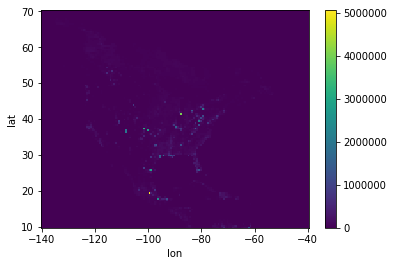

In [13]:
# retrieve all of the data at the native resolution into memory and plot
output = node.eval(node.native_coordinates)
output.plot()
pass